In [1]:
#this note book check if tcax.z.hat provides additional info on top of W, X
#fits a model:  Z_jh ~ W_h + X_j + Z_jh.tcax across i, for all i, h on the sc-stephenson data 

In [2]:
library("MASS")
library("testit")
library("pracma")
library("data.table")
library("matrixStats")
#library("compositions")

source("analysis.utils.r")
source("simulate.expression.utils.r")

library("ggplot2")
library("ggpubr")
library("grid")
library("tidyr")
library("scales")
library("latex2exp")
library("hrbrthemes")
library("extrafont")
library("ggpointdensity")

Warning message:
“package ‘MASS’ was built under R version 4.1.3”
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Registering fonts with R



In [3]:
data.dir       = "../Data/RNA/Simulation-Lung/sc-HLCA_all.W_decon.L1_HEF.10k_k_4_m_600_n_500_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_3_scale.maxSds_Inf_scale.factor.thr_1e-04/"
res.dir        = "../Result/RNA/Simulation-Lung/sc-HLCA_all.W_decon.L1_HEF.10k_k_4_m_600_n_500_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0_enrich_F_etpRat_0_enrichRat_0_maxSds_3_scale.maxSds_Inf_scale.factor.thr_1e-04/"

base.mdl.list       = readRDS(file.path(res.dir,"base.mdl.list.rds"))
cibersortx.mdl.list = readRDS(file.path(res.dir,"cibersortx.mdl.list.rds"))
tca.mdl.list        = readRDS(file.path(res.dir,"tca.mdl.list.rds"))
tcax.mdl.list       = readRDS(file.path(res.dir,"tcax.mdl.mp_0_vp_0.01_cp_0.01.list.rds"))

ts = 1:20

In [4]:
sim.data.list = readRDS(file.path(data.dir,paste0("sim.data.list.rds")))
for (t in ts){
    #sim.data.list[[t]] = readRDS(file.path(data.dir,paste0("sim.data.rds.", t)))
    sim.data.list[[t]]$eval.feature.source = calc_variable_feature_source(Z = sim.data.list[[t]]$Z.scale, 
                                                                          variable_thr = 0.1, max_sds = 3)
}

sim.data = sim.data.list[[1]]
k = ncol(sim.data$W)
m = nrow(sim.data$X)
n = ncol(sim.data$X)
source.ids = colnames(sim.data$W)

In [5]:
#log.p.vals.mats: list of matrix. names are the source.ids, each matrix is features by some columns. each entry is a p val
#var.to.plt: character. column name in log.p.vals.mat of the variable to plot 
#source.ids: list of character. source to show
#visualize each source.id as a figure. different source.id will be shown as different panel. 
#each panel's x axis are features. y axis is negtive log pval
manplot = function(log.p.vals.mats, var.to.plt, source.ids){
    k = length(log.p.vals.mats)
    plts<- lapply(1:k, function(h){
        source.id = source.ids[h]
        df = as.data.frame(log.p.vals.mats[[source.id]])
        df[df>300] = 300
        df$j = 1:nrow(log.p.vals.mats[[source.id]]) 
        g = ggplot(df, aes(x = j, y = df[,var.to.plt])) +
            geom_point(alpha = 1, size = 1) + 
            ggtitle(paste0(source.id)) +  
            theme(plot.title = element_text(hjust = 0.5, size = 15))+ theme(text=element_text(size=15))+ 
            ylab("negative log10 p val") +
            #clean background 
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.title.x = element_blank(),
                  axis.line = element_line(colour = "black"))
        return(g)
    })
    return (egg::ggarrange(plots = plts, align = "h", widths = rep(1, k))) 

}

In [30]:
get_log_p_vals_mats = function(X, W, Z, Z.hat, num.stds = 2, eval.feature.source){
# for each gene fit a joint model and reported the p-val on each terms
# per gene the outliers defined by the num.stds are removed
    source.ids  = colnames(W)
    feature.ids = rownames(X)
    res = list()
    for (source.id in source.ids){
        print(paste0("working on ", source.id))
        p.vals.mat  = list()
        for (feature.id in feature.ids){
            print(feature.id)
            # if this feature source is turned on to be evaluated 
            if (eval.feature.source[feature.id, source.id]){
                df = data.frame(Z.hat = log(1 + pmax(0,Z.hat[source.id,feature.id,])), 
                                bulk  = log(1 + X[feature.id, ]), 
                                Z     = Z[source.id,feature.id,])
                df = cbind(df, W[, -1]) # drop one column of W to prevent co-linear
                
                #filter out outliers before entering regression 
                x = X[feature.id, ]
                mask = abs(x - mean(x)) <= num.stds * sd(x)
                df = df[mask, ]

                #regression 
                fit = lm(formula = Z ~ ., data = df) 
                fit.coef = t(summary(fit)$coefficients)["Pr(>|t|)", , drop = F]
                rownames(fit.coef) = c(feature.id)
                p.vals.mat[[feature.id]] = fit.coef
            }
        }
        p.vals.mat = Reduce(rbind, p.vals.mat)
        res[[source.id]] = -log10(p.vals.mat)
    }
    return(res)
}

# Joint regression

In [20]:
base.mdl.list[[t]]$Z.hat.eval[4,,]

sample.1    sample.2    sample.3     sample.4     sample.5   
ENSG00000184990 0.029821158 0.057031658 0.0104423704 0.0253427227 0.182749216
ENSG00000148053 0.000000000 0.004859552 0.0017235731 0.0000000000 0.002607575
ENSG00000204713 0.025018416 0.042641077 0.0025643200 0.0087772691 0.072186714
ENSG00000157077 0.009821579 0.050938651 0.0008019172 0.0028172010 0.049786919
ENSG00000007341 0.019886719 0.054788594 0.0025973733 0.0075994581 0.076981281
ENSG00000178585 0.016038142 0.030254014 0.0053142264 0.0094332535 0.147473982
ENSG00000147383 0.021293850 0.042135778 0.0035544573 0.0084274683 0.109325725
ENSG00000136930 0.059139417 0.034937677 0.0041488404 0.0125939143 0.166695366
ENSG00000139631 0.031758315 0.032930300 0.0020648489 0.0105514951 0.122160796
ENSG00000153446 0.102925919 0.032617122 0.0080695397 0.0012081969 0.068377391
ENSG00000206199 0.000000000 0.016203544 0.0054192111 0.0000502847 0.059254174
ENSG00000127666 0.024885923 0.055412561 0.0018874852 0.0101112712 0.181768130
ENSG00000178695 0.033469406 0.012617206 0.0018858666 0.0030949618 0.061745213
ENSG00000125741 0.072249040 0.042450330 0.0044302268 0.0090653441 0.165275939
ENSG00000167642 0.025353448 0.081494950 0.0100517686 0.0052756060 0.144375659
ENSG00000115112 0.053992740 0.004466035 0.0055489560 0.0033917010 0.056396430
ENSG00000141994 0.006432878 0.022149417 0.0020369651 0.0086013725 0.038209875
ENSG00000132603 0.084900539 0.047745459 0.0023643016 0.0106047071 0.072522375
ENSG00000149792 0.092274543 0.056410785 0.0050022939 0.0213769648 0.133409055
ENSG00000130159 0.051264910 0.087888578 0.0066512173 0.0281366276 0.199337051
ENSG00000109381 0.051335501 0.052684706 0.0027043574 0.0194091531 0.106897213
ENSG00000115339 0.028044215 0.043548084 0.0064575818 0.0042251096 0.068426956
ENSG00000131378 0.055044519 0.037792917 0.0036960424 0.0164146332 0.045309687
ENSG00000134321 0.000000000 0.027608431 0.0023904013 0.0046369774 0.052686109
ENSG00000136352 0.019419652 0.047626436 0.0054789910 0.0032088573 0.081816510
ENSG00000164023 0.179166714 0.007544251 0.0038586712 0.0012409838 0.092426220
ENSG00000129353 0.049787319 0.033210215 0.0032318774 0.0235497689 0.065500698
ENSG00000163527 0.047056801 0.022728997 0.0034824387 0.0071438467 0.071395298
ENSG00000160472 0.000000000 0.028904736 0.0058347589 0.0001124842 0.077329845
ENSG00000178498 0.010245356 0.022495547 0.0014696347 0.0034704754 0.021467247
⋮               ⋮           ⋮           ⋮            ⋮            ⋮          
ENSG00000170006 0.010231933 0.028401278 3.412553e-03 0.0049511209 0.04472117 
ENSG00000215193 0.024355768 0.034968342 6.130353e-03 0.0193358889 0.07095865 
ENSG00000130958 0.012705128 0.018436357 3.963153e-03 0.0113479919 0.05836056 
ENSG00000155368 0.116594101 0.023179917 5.386963e-03 0.0078010238 0.12390859 
ENSG00000141424 0.045643907 0.079277850 8.258970e-03 0.0084571784 0.11159199 
ENSG00000166272 0.034118222 0.014484728 2.633298e-03 0.0097097305 0.06666315 
ENSG00000151914 0.031173485 0.011019671 4.094896e-04 0.0050527014 0.04181069 
ENSG00000120899 0.085776207 0.027544023 1.633338e-03 0.0244619065 0.06406309 
ENSG00000116991 0.053532017 0.006769590 1.855523e-03 0.0043236448 0.05323174 
ENSG00000085832 0.060798150 0.025240483 3.557164e-03 0.0164191346 0.07855939 
ENSG00000129472 0.045278128 0.038973918 4.308334e-03 0.0112227594 0.09518145 
ENSG00000100804 0.035590818 0.083605322 9.001338e-03 0.0067587101 0.22109330 
ENSG00000188243 0.102362957 0.065035754 7.419239e-03 0.0366504108 0.20022186 
ENSG00000135245 0.018264328 0.016743994 2.611603e-04 0.0003091194 0.03818514 
ENSG00000127955 0.008899913 0.029343776 2.677159e-03 0.0007447760 0.09305970 
ENSG00000057608 0.067764297 0.032650645 3.951314e-03 0.0160071824 0.09288085 
ENSG00000132964 0.016202167 0.020706531 1.961873e-04 0.0046677788 0.02741368 
ENSG00000116898 0.042698002 0.033818399 8.549552e-03 0.0117929993 0.15022706 
ENSG00000214753 0.113429432 0.016819234 4.496720e-03 0.0161778742 0.10526353 
ENSG00000168769 0.038539794 0.00768469

In [29]:
cibersortx.mdl.list[[t]]$Z.hat.eval[5,,]

ERROR: Error in cibersortx.mdl.list[[t]]$Z.hat.eval[5, , ]: subscript out of bounds


In [ ]:
# a list, per element stores result for one run 
# per element: a list of all methods's p val
p.vals.mats.list = list()
for (t in ts){
    p.vals.mats = list()
    p.vals.mats[["Baseline"]] = get_log_p_vals_mats(X = sim.data.list[[t]]$X.scale, 
                                                      W = sim.data.list[[t]]$W, 
                                                      Z = sim.data.list[[t]]$Z.scale,
                                                      Z.hat = base.mdl.list[[t]]$Z.hat.eval,
                                                      num.stds = 2,
                                                      eval.feature.source = sim.data.list[[t]]$eval.feature.source)
    print("a")
    p.vals.mats[["CIBSERSORTx"]] = get_log_p_vals_mats(X = sim.data.list[[t]]$X.scale, 
                                                      W = sim.data.list[[t]]$W, 
                                                      Z = sim.data.list[[t]]$Z.scale,
                                                      Z.hat = cibersortx.mdl.list[[t]]$Z.hat.eval,
                                                      num.stds = 2,
                                                      eval.feature.source = sim.data.list[[t]]$eval.feature.source)
    p.vals.mats[["TCA"]] = get_log_p_vals_mats(X = sim.data.list[[t]]$X.scale, 
                                                      W = sim.data.list[[t]]$W, 
                                                      Z = sim.data.list[[t]]$Z.scale,
                                                      Z.hat = tca.mdl.list[[t]]$Z.hat.eval,
                                                      num.stds = 2,
                                                      eval.feature.source = sim.data.list[[t]]$eval.feature.source)
    p.vals.mats[["TCAx"]] = get_log_p_vals_mats(X = sim.data.list[[t]]$X.scale, 
                                                      W = sim.data.list[[t]]$W, 
                                                      Z = sim.data.list[[t]]$Z.scale,
                                                      Z.hat = tcax.mdl.list[[t]]$Z.hat.eval,
                                                      num.stds = 2,
                                                      eval.feature.source = sim.data.list[[t]]$eval.feature.source)
    p.vals.mats.list[[t]] = p.vals.mats
}

str(p.vals.mats.list)

In [7]:
str(sim.data.list[[1]])

List of 14
 $ source.ids             : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
 $ feature.ids            : chr [1:600] "ENSG00000184990" "ENSG00000148053" "ENSG00000204713" "ENSG00000157077" ...
 $ sample.ids             : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
 $ W                      : num [1:500, 1:4] 0.59568 0.23242 0.00899 0.67114 0.29463 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
  .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
 $ Z                      : num [1:4, 1:600, 1:500] 41.3 24 56.8 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
  .. ..$ : chr [1:600] "ENSG00000184990" "ENSG00000148053" "ENSG00000204713" "ENSG00000157077" ...
  .. ..$ : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
 $ X                      : num [1:600, 1:500] 33.41 0 11.95 1.83 4.34 ...
  ..- attr(*, "dimna

In [8]:
str(tca.mdl.list[[1]])

List of 7
 $ params.hat.eval   :List of 13
  ..$ W                     : num [1:500, 1:4] 0.59568 0.23242 0.00899 0.67114 0.29463 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:500] "sample.1" "sample.2" "sample.3" "sample.4" ...
  .. .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
  ..$ mus_hat               : num [1:600, 1:4] 2.32536 0.00001 1.71972 0.11863 1.16088 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:600] "ENSG00000184990" "ENSG00000148053" "ENSG00000204713" "ENSG00000157077" ...
  .. .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
  ..$ sigmas_hat            : num [1:600, 1:4] 0.565 0.01 0.926 0.01 0.383 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:600] "ENSG00000184990" "ENSG00000148053" "ENSG00000204713" "ENSG00000157077" ...
  .. .. ..$ : chr [1:4] "Immune" "Epithelial" "Endothelial" "Stroma"
  ..$ tau_hat               : Named num 0.512
  .. ..- attr(*, "names")= chr ""
  ..$ deltas_h

In [9]:
cibersortx.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z,
                                      Z.hat = cibersortx.mdl.list[[1]]$Z.hat.orig,
                                      num.stds = 2,
                                      eval.feature.source = sim.data.list[[1]]$eval.feature.source)

base.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z,
                                      Z.hat = base.mdl.list[[1]]$Z.hat.orig,
                                      num.stds = 2,
                                           eval.feature.source = sim.data.list[[1]]$eval.feature.source)

tca.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z,
                                      Z.hat = tca.mdl.list[[1]]$Z.hat.orig,
                                      num.stds = 2,
                                          eval.feature.source = sim.data.list[[1]]$eval.feature.source)

tcax.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z,
                                      Z.hat = tcax.mdl.list[[1]]$Z.hat.orig,
                                      num.stds = 2,
                                           eval.feature.source = sim.data.list[[1]]$eval.feature.source)

[1] "working on Immune"


ERROR: Error in f(init, x[[i]]): number of columns of matrices must match (see arg 2)


In [ ]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

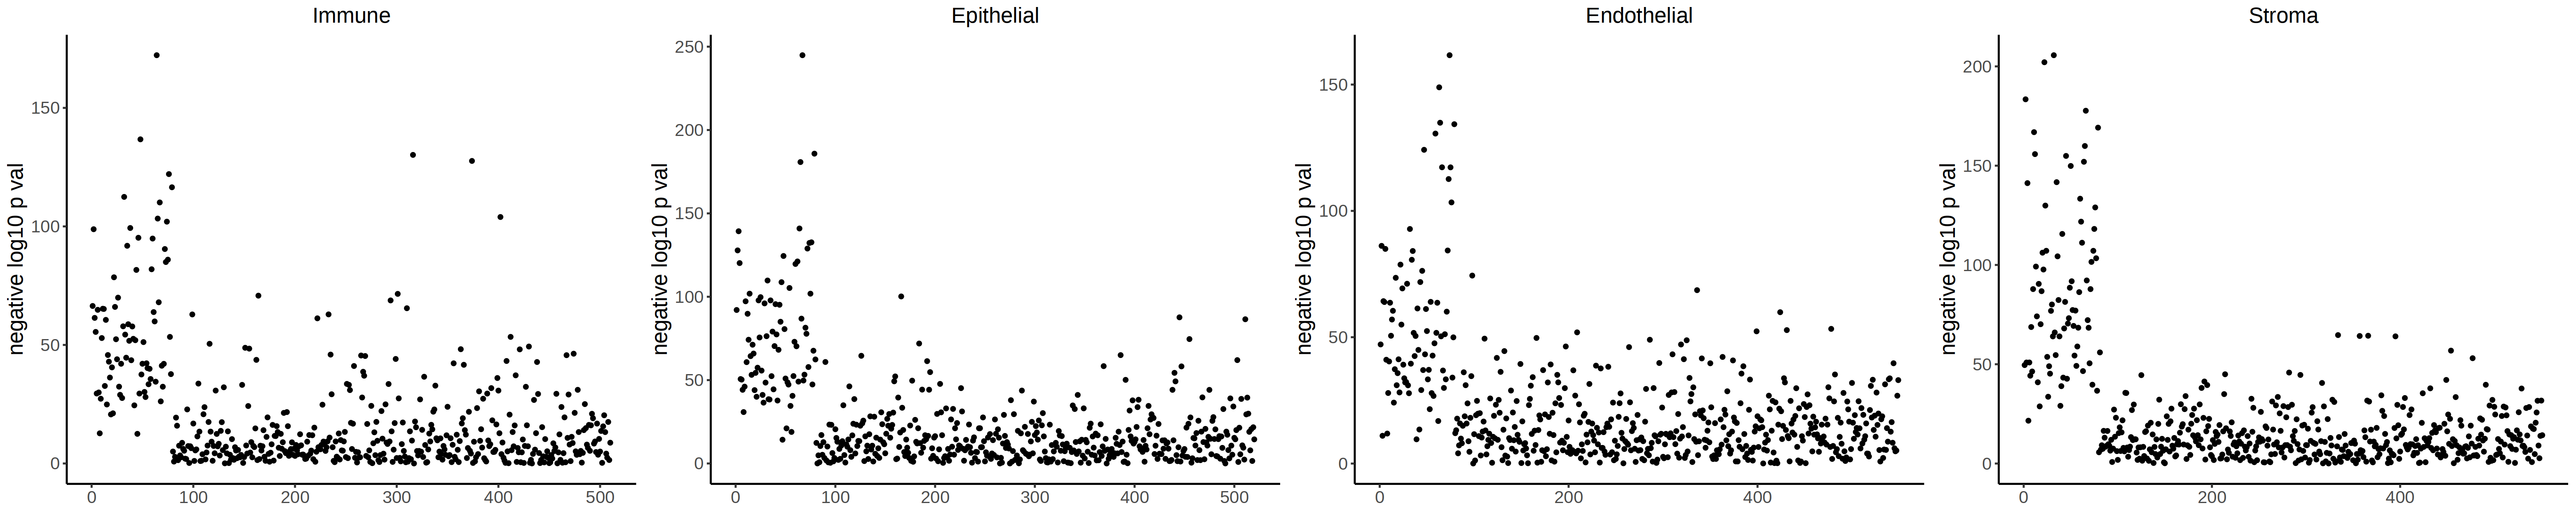

In [13]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

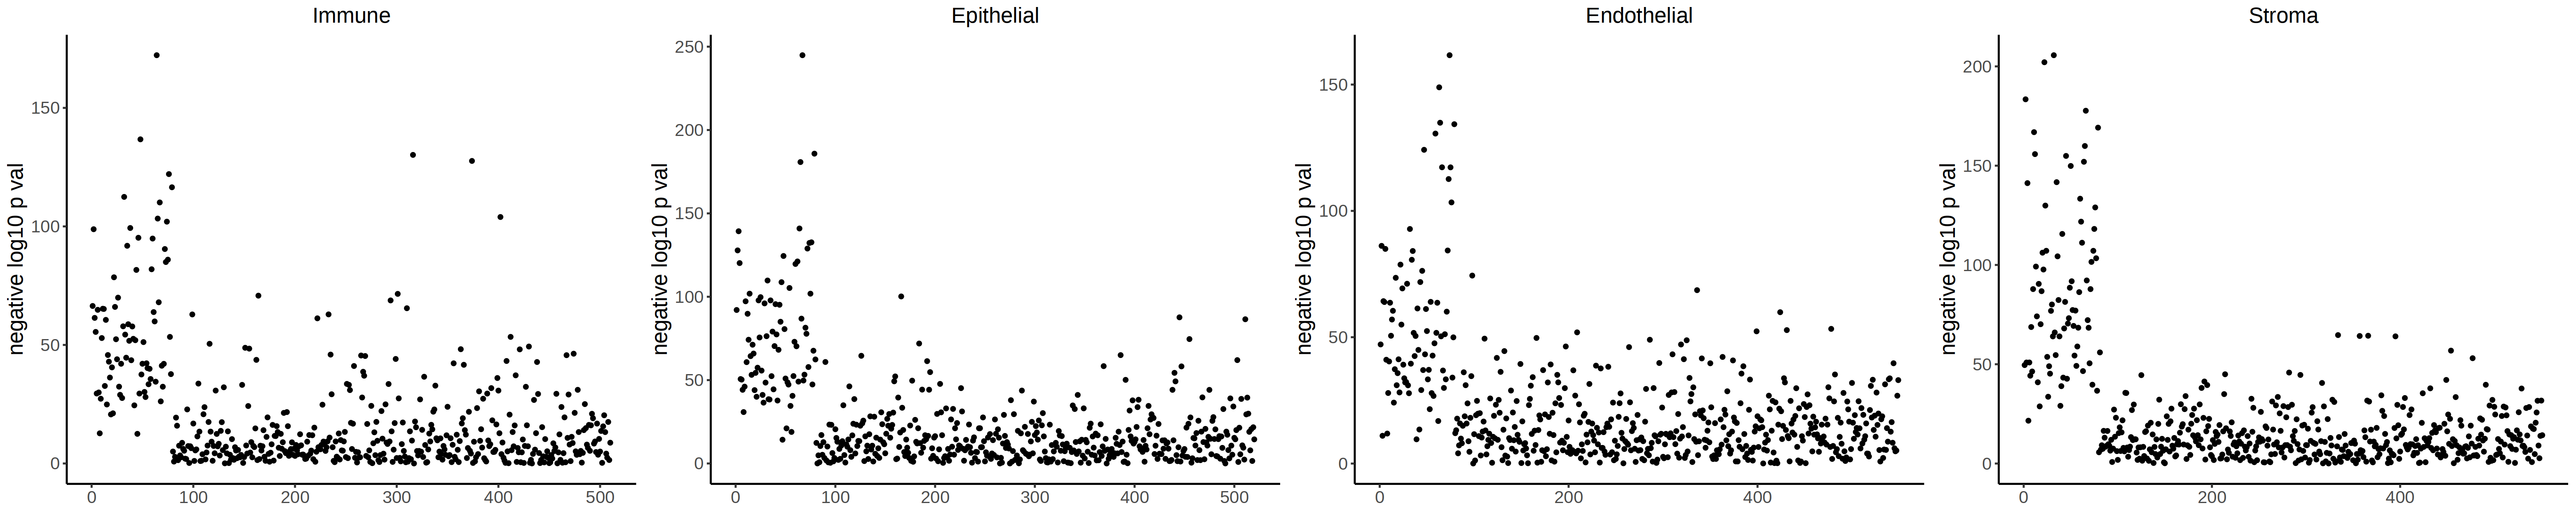

In [14]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(cibersortx.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

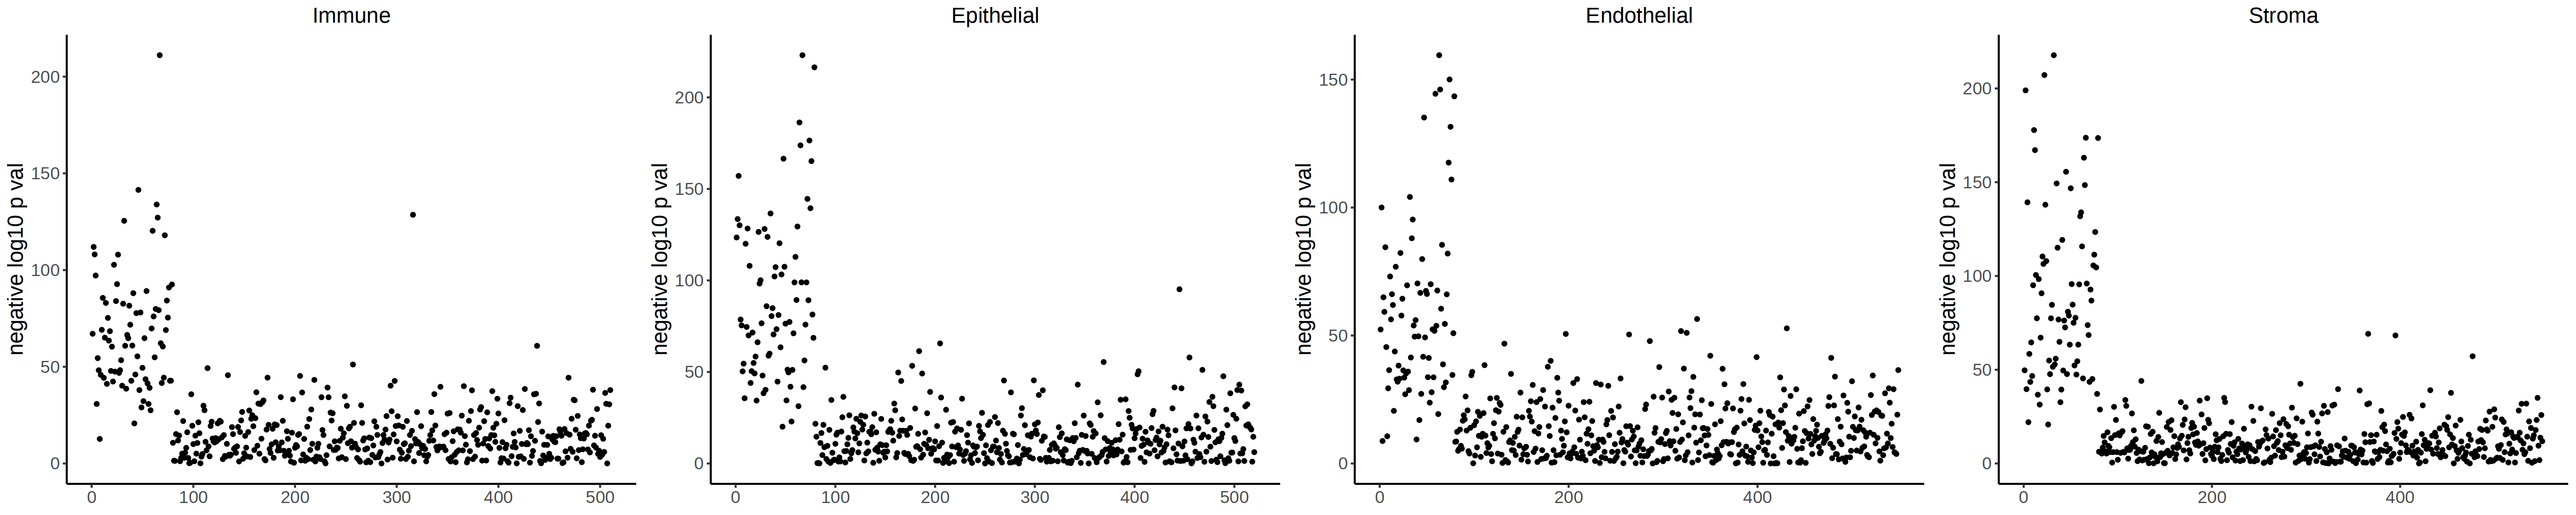

In [15]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tca.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

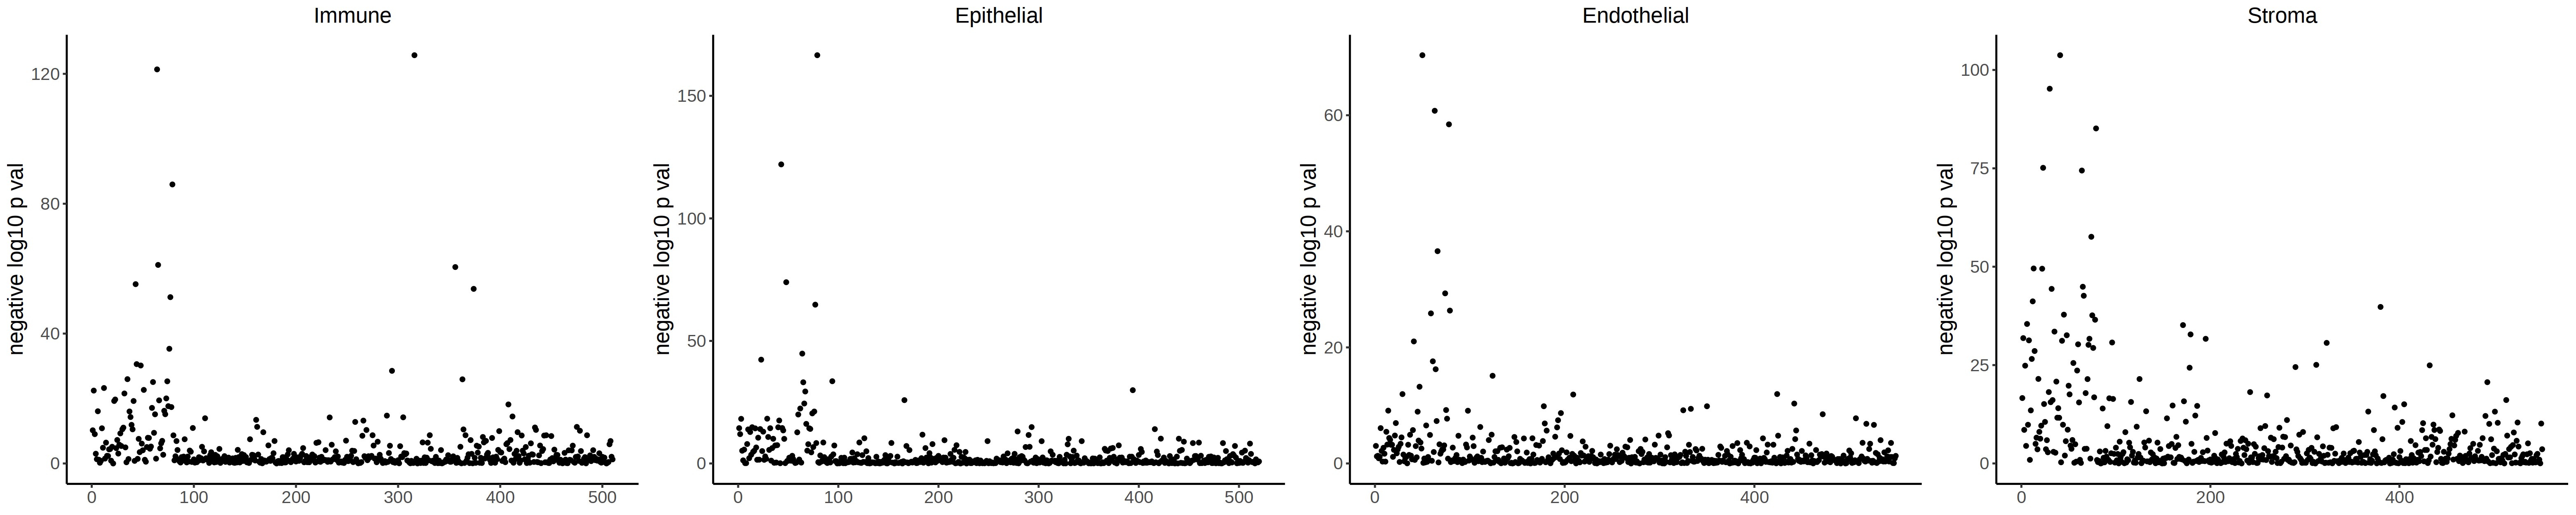

In [16]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tcax.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

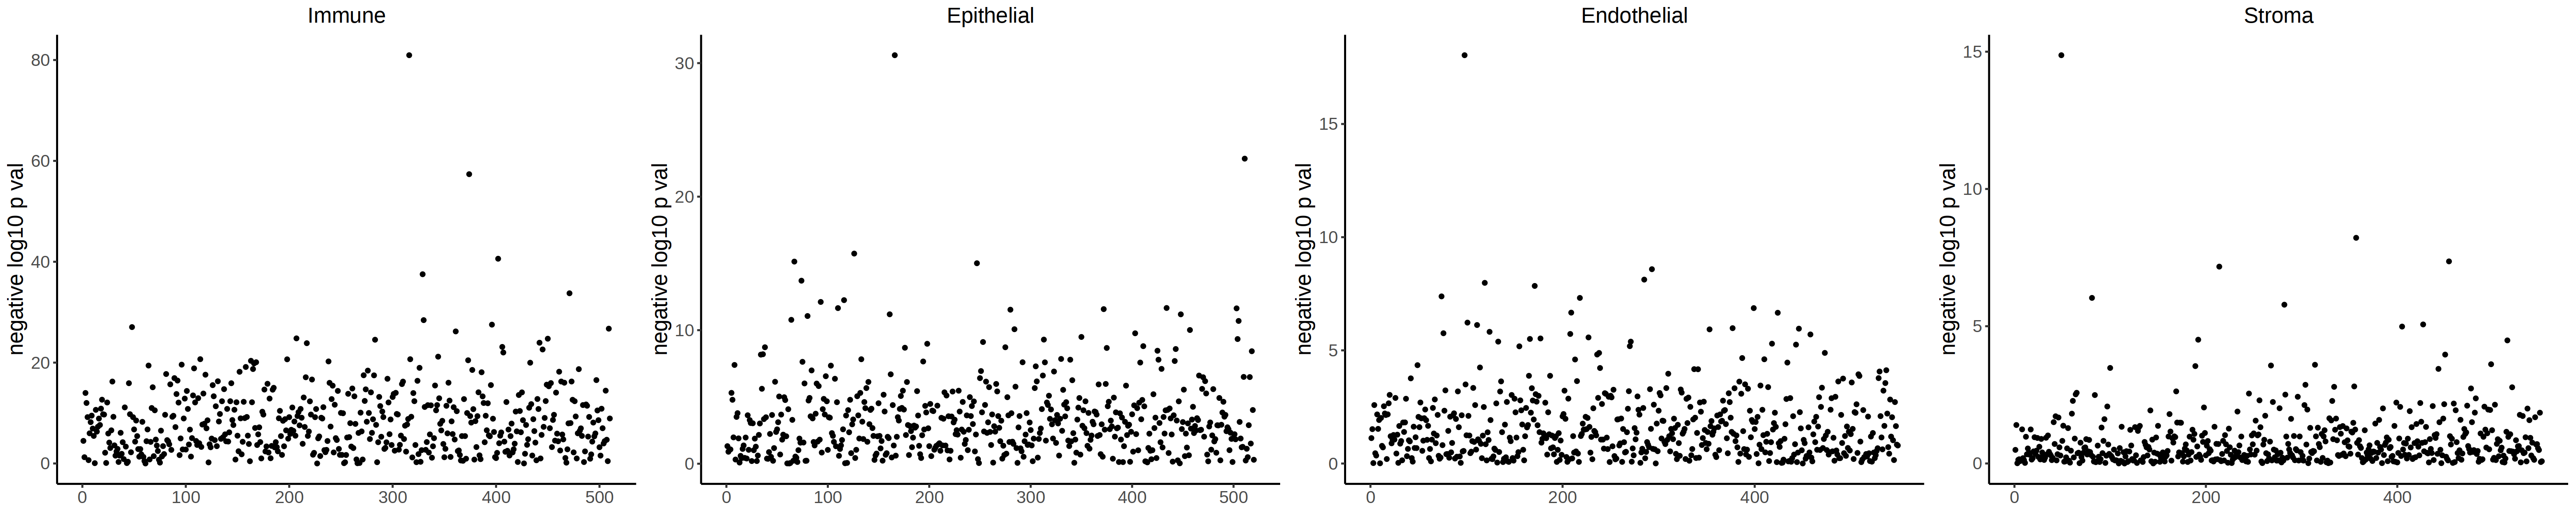

In [17]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

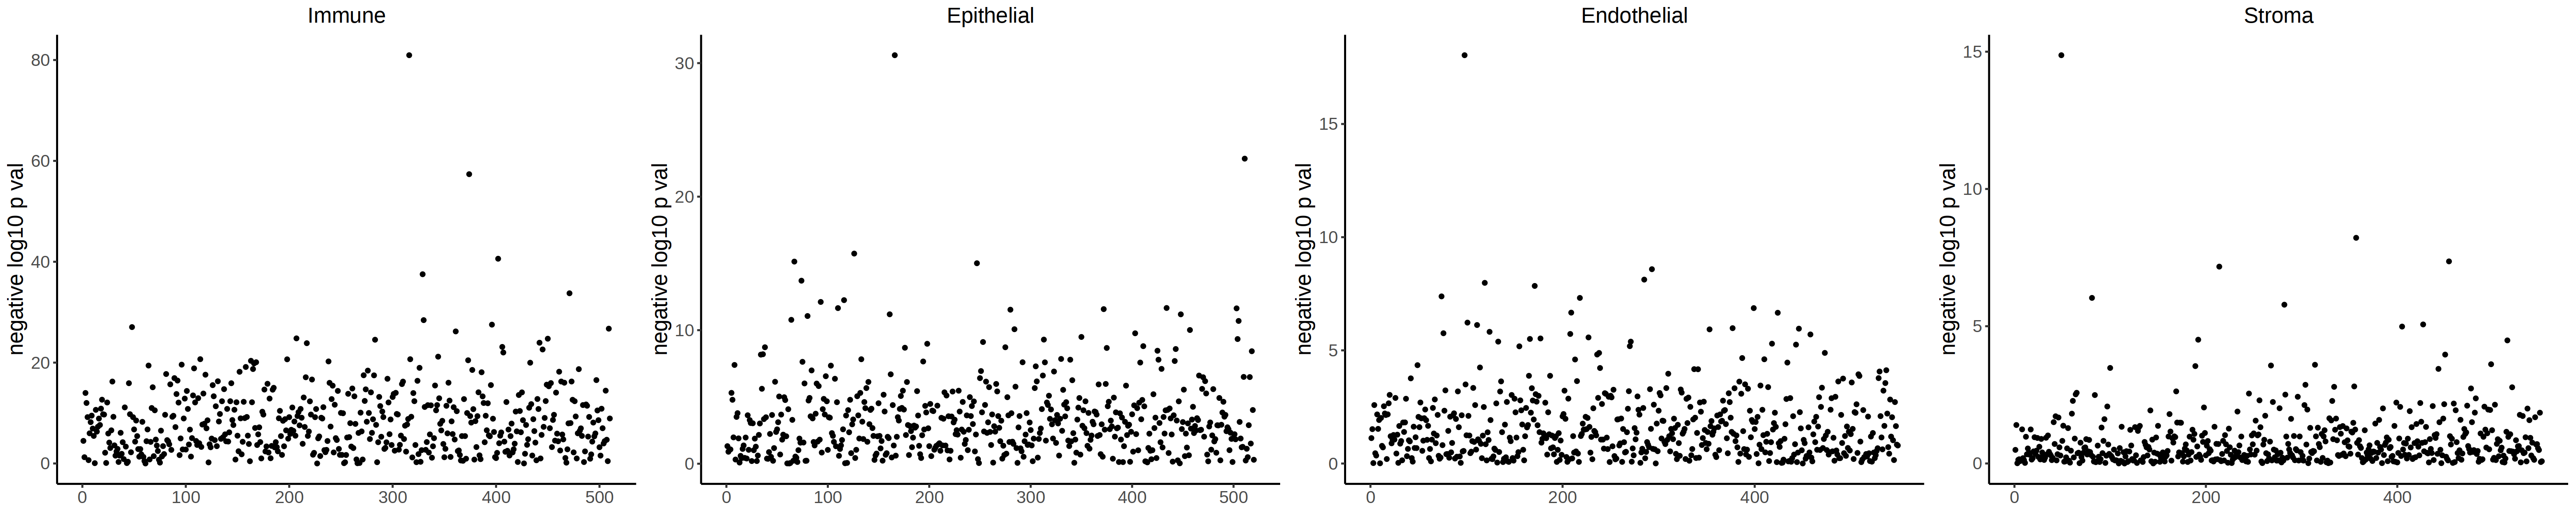

In [18]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(cibersortx.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

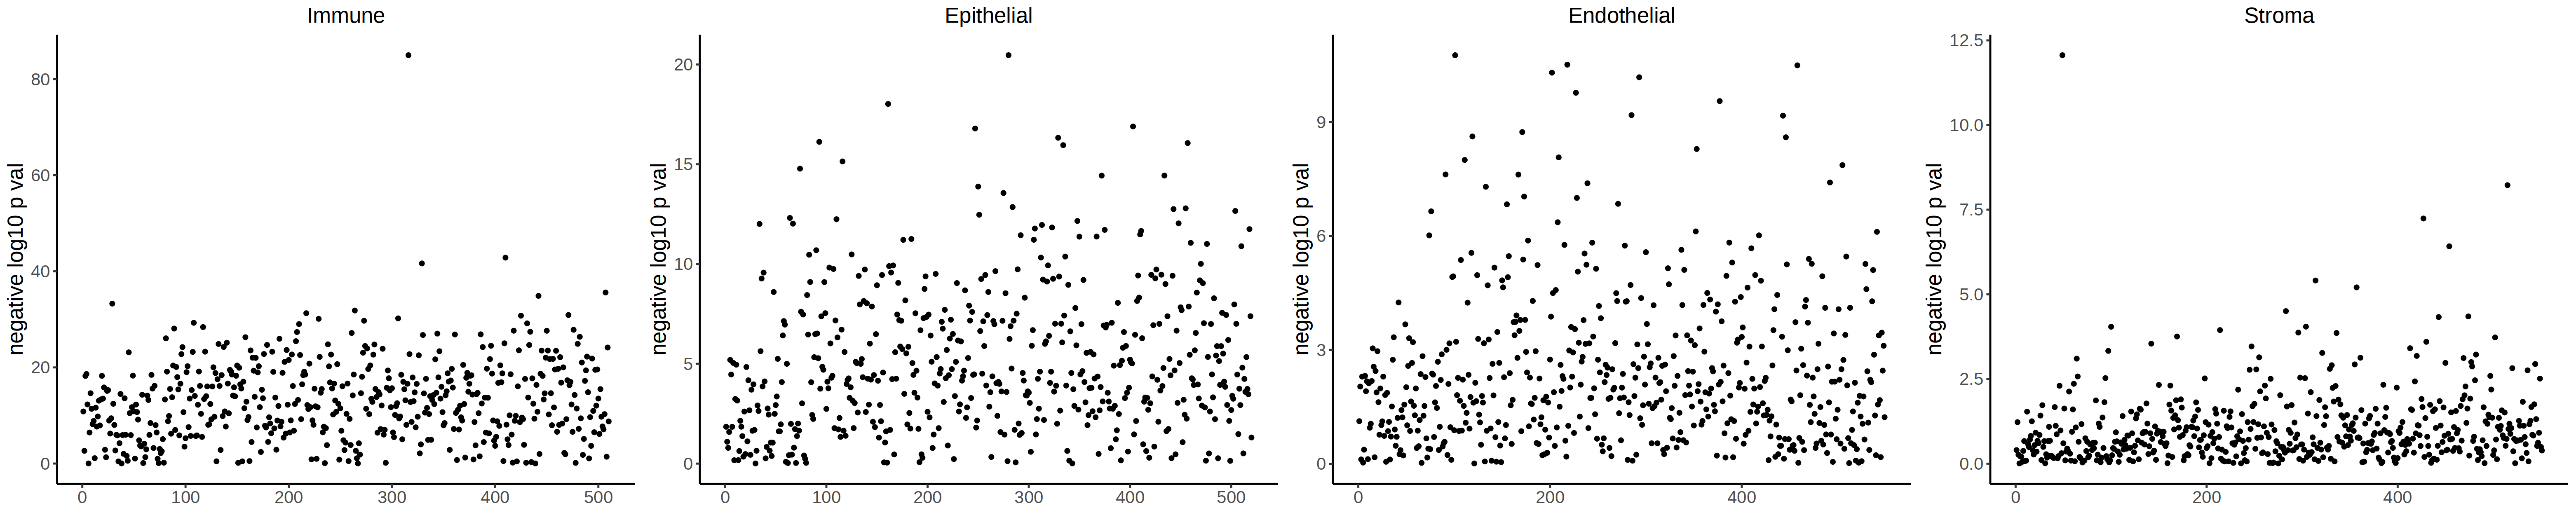

In [19]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tca.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

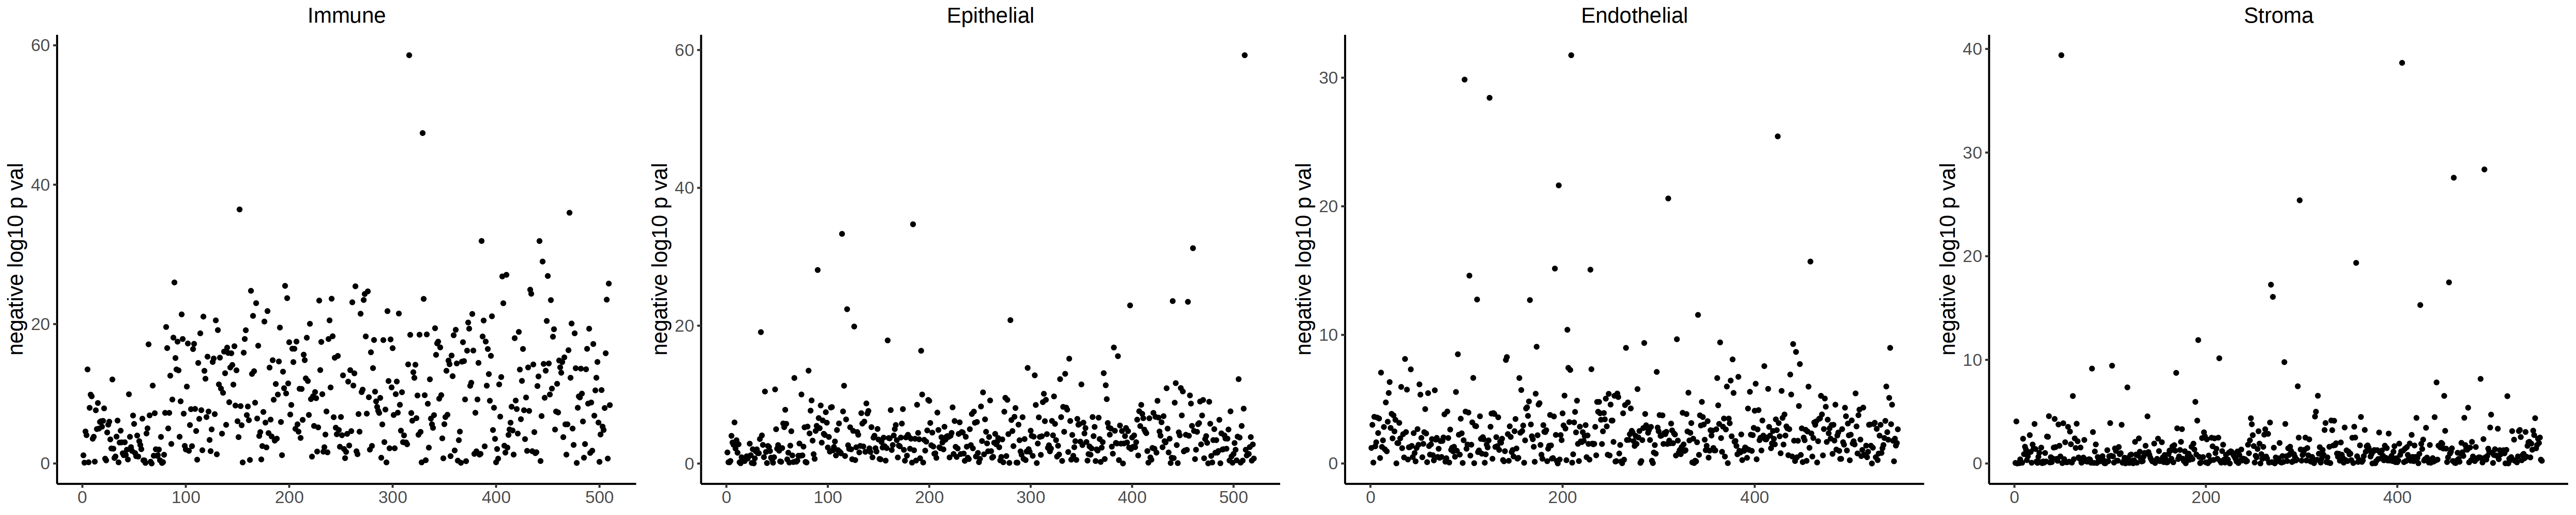

In [20]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tcax.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

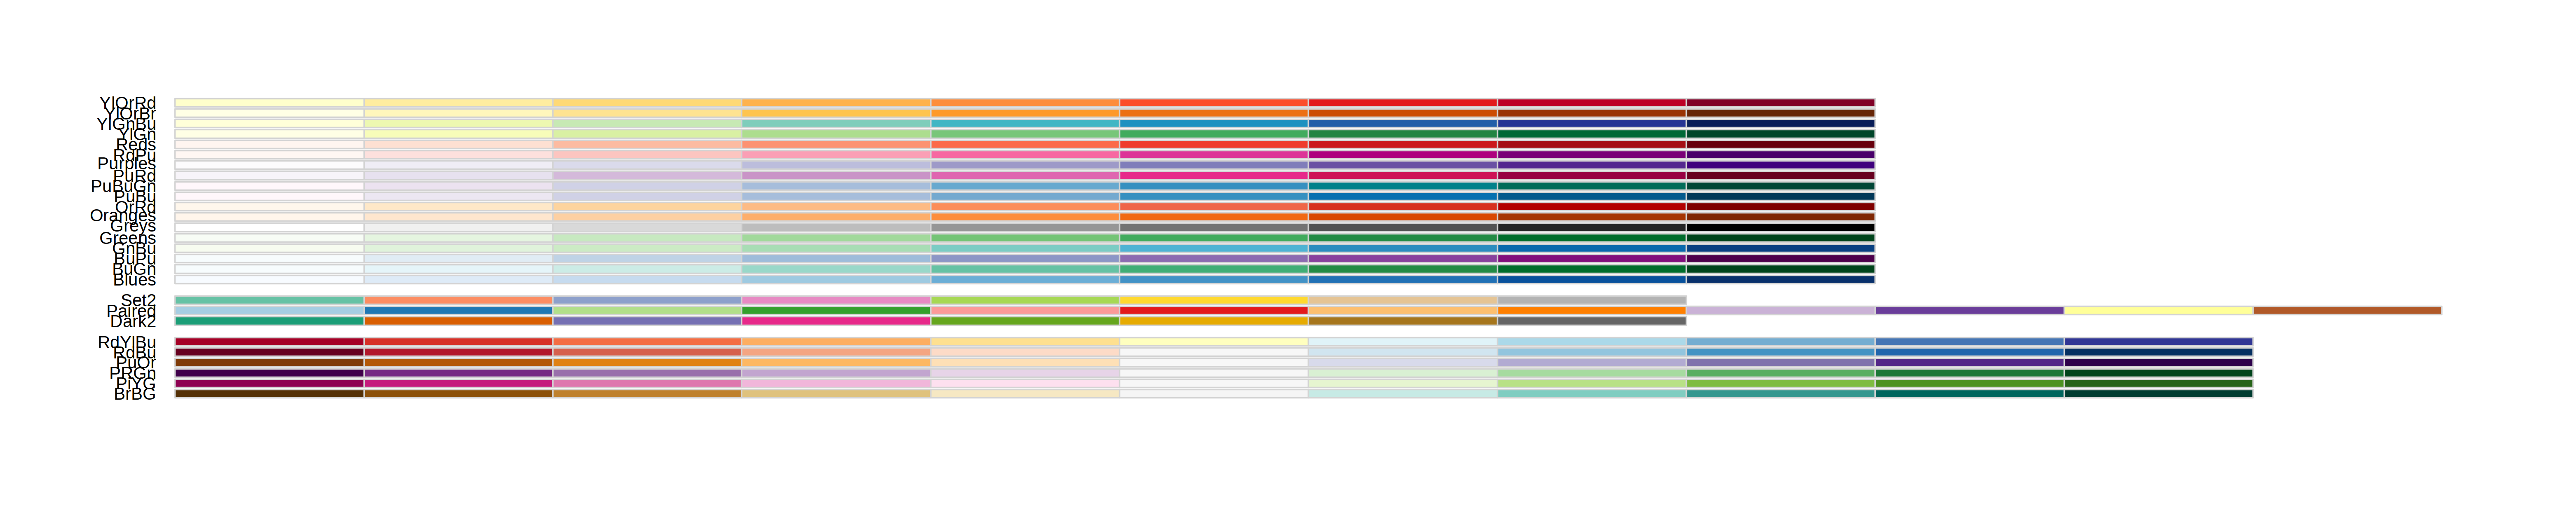

In [21]:

########################################### Color code ################################################
library(RColorBrewer)


display.brewer.all(colorblindFriendly = TRUE)
base.color = brewer.pal(n = 8, name = "Set2")[8]
bulk.color = brewer.pal(n = 8, name = "Set2")[7]
cibersortx.color = brewer.pal(n = 8, name = "Set2")[5]
tca.color  = brewer.pal(n = 8, name = "Set2")[3]
tcax.color = brewer.pal(n = 8, name = "Set2")[4]


In [24]:
source.ids

[1] "Immune"      "Epithelial"  "Endothelial" "Stroma"

In [25]:
sub.titles = source.ids
dot.alpha = 0.75
dot.size  = 3
title.size = 25
lab.size = 20
xlab.text = "Bulk"
ylab.text = "Deconvolution Tensor"

In [26]:
methods = c("Baseline", "CIBERSORTx", "TCA", "TCAx")
log.p.vals.mats.list = list("Baseline" = base.log.p.vals.mats,
                            "CIBERSORTx" = cibersortx.log.p.vals.mats,
                            "TCA" = tca.log.p.vals.mats,
                            "TCAx" = tcax.log.p.vals.mats)

In [35]:
plts = list()
#for (h in 1:length(source.id)){
for (h in 1:1){
    source.id = source.ids[h]
    
    plot.df = data.frame(matrix(ncol = 3, nrow = 0))
    colnames(plot.df) = c("x", "y", "method")
    for (method in methods){
        method.df = data.frame(x = log.p.vals.mats.list[[method]][[source.id]][,"bulk"],
                               y = log.p.vals.mats.list[[method]][[source.id]][,"Z.hat"],
                               method = rep(method, nrow(log.p.vals.mats.list[[method]][[source.id]])))
        # remove outliers
        method.thr = min(quantile(as.vector(method.df$x), 0.975, na.rm = T), 
                         quantile(as.vector(method.df$y), 0.975, na.rm = T))
  
        method.df = method.df[(method.df$x < method.thr) & 
                              (method.df$y < method.thr) ,]
        plot.df = rbind(plot.df, method.df)
        
        
    }
    # cap extreme pvals
    #plot.df[,c("x", "y")][plot.df[,c("x", "y")]>300] = 300;
    #print("super small pvals are set to -log10 300")
    
    
#                         quantile(as.vector(plot.df$y), 0.95, na.rm = T))
    
    # factorize
    plot.df$method = factor(plot.df$method, levels = c("Baseline","CIBERSORTx", "TCA","TCAx"))

    model.vis.thr = max(plot.df$x) * 1.1
    
    # NA
    print(sum(plot.df[,c("x", "y")], na.rm = T))
    
   


    g = ggplot(plot.df, aes(x = y, y = x, fill = method, color = method)) +
        geom_point(alpha = dot.alpha, size = dot.size) + 
        geom_smooth(method = "lm",
                    formula = y ~ 0 + x, 
                    data = plot.df,
                    #data=subset(plot.df, x < model.fit.thr, y < model.fit.thr),
                    fullrange = T) + 
        scale_colour_manual(values = c(base.color, cibersortx.color, tca.color, tcax.color), name=NULL) + 
        scale_fill_manual(values = c(base.color, cibersortx.color, tca.color, tcax.color), name=NULL) + 
        geom_abline(slope=1, colour= "black", linetype = "dashed") + 
        coord_cartesian(xlim = c(0, model.vis.thr),ylim = c(0, model.vis.thr))+
    
        theme_classic() +
        ggtitle(paste0(sub.titles[h]," (", round(colMeans(sim.data$W)[h], 2) * 100, "%)")) +  
        theme(plot.title = element_text(hjust = 0.5, size=title.size)) + 
    
        xlab(parse(text = paste0("\'",xlab.text,"\'~", expression(-log[10](P))))) +
        ylab(parse(text = paste0("\'",ylab.text,"\'~", expression(-log[10](P))))) +
        theme(axis.title.x = element_text(size = lab.size)) + 
        theme(axis.text.x  = element_text(size = lab.size)) + 
        theme(axis.title.y = element_text(size = lab.size)) +
        theme(axis.text.y  = element_text(size = lab.size))  +
        theme(legend.text=element_text(size= lab.size))

    if(h!= k){g = g + theme(legend.position = "none")}
    plts[[h]] = g
}


[1] 27382.19


In [37]:
#plts

In [28]:
plot.df 

x          y          method  
ENSG00000102317  12.7157802  8.195885  Baseline
ENSG00000137154  20.6888932 12.647306  Baseline
ENSG00000142534  21.1532969  9.698684  Baseline
ENSG00000182768  12.4969428 15.915264  Baseline
ENSG00000123595   5.0289927  9.653162  Baseline
ENSG00000144848   0.8008459 17.735686  Baseline
ENSG00000067064   2.8018603  4.628687  Baseline
ENSG00000249915  19.3386190  4.372340  Baseline
ENSG00000175416  15.9229576  3.799247  Baseline
ENSG00000256537   1.3838961 15.692342  Baseline
ENSG00000099860   7.5016550  2.697720  Baseline
ENSG00000116560   3.3803756  9.258127  Baseline
ENSG00000205339   2.5980124  9.454897  Baseline
ENSG00000006015   8.7034552 16.925311  Baseline
ENSG00000112531   6.1629117  7.215158  Baseline
ENSG00000102144   5.3744560 13.769248  Baseline
ENSG00000105755   2.0214115 16.440171  Baseline
ENSG00000087460   1.8847504 12.076101  Baseline
ENSG00000234745  22.8042549  1.659304  Baseline
ENSG00000164687   7.3437184  4.965903  Baseline
ENSG00000145901   0.2023904 19.596683  Baseline
ENSG00000120725   7.2551376  2.787437  Baseline
ENSG00000139613   6.4501714  8.924570  Baseline
ENSG00000154518  16.8470730  2.762921  Baseline
ENSG00000123505   1.0724894 14.379402  Baseline
ENSG00000155660   5.5126289 10.814410  Baseline
ENSG00000073584   5.9328078  3.764117  Baseline
ENSG00000156976  11.4155792  6.715873  Baseline
ENSG00000196976  13.4359094  5.030368  Baseline
ENSG00000091140   1.0276587 13.493531  Baseline
⋮                ⋮          ⋮          ⋮       
ENSG000001844323 0.20410523  9.6267982 TCAx    
ENSG000001636443 0.60482552  9.4742390 TCAx    
ENSG000001258103 1.47990875 13.6065094 TCAx    
ENSG000001981603 1.95794425 10.0232437 TCAx    
ENSG000001969613 0.04282580  6.0288875 TCAx    
ENSG000001143531 8.68561690  0.8273276 TCAx    
ENSG000001329633 1.09003227  2.7838894 TCAx    
ENSG000001109583 1.18538783 13.5163426 TCAx    
ENSG000001003533 2.49213470 16.4533470 TCAx    
ENSG000001790103 0.72699784  8.5913348 TCAx    
ENSG000000678293 1.55471183 19.3378499 TCAx    
ENSG000001975363 4.08179208  1.5133500 TCAx    
ENSG000002055443 2.03963973  8.7489124 TCAx    
ENSG000001020072 1.02735694  1.8376073 TCAx    
ENSG000001371333 1.44235842 17.1409558 TCAx    
ENSG000001177133 0.86411122  6.8591736 TCAx    
ENSG000001375003 1.22353624 10.4867136 TCAx    
ENSG000001721153 3.13492162 12.3030038 TCAx    
ENSG000001977473 0.47138047 14.5659822 TCAx    
ENSG000001118323 0.25385764  5.8687676 TCAx    
ENSG000001351853 2.04308543  0.2350768 TCAx    
ENSG000000897373 0.53997378  4.1602125 TCAx    
ENSG000001345313 1.80195143 10.5333770 TCAx    
ENSG000001864683 0.27433707  5.2883406 TCAx    
ENSG000001828993 0.01273866  4.8077372 TCAx    
ENSG000001155242 0.21960155  7.9588418 TCAx    
ENSG000001365222 0.44858821 15.8161346 TCAx    
ENSG000001168572 5.91331350 23.5065467 TCAx    
ENSG000001404553 6.90606220  0.7045856 TCAx    
ENSG000000338002 1.25965198  8.3740173 TCAx

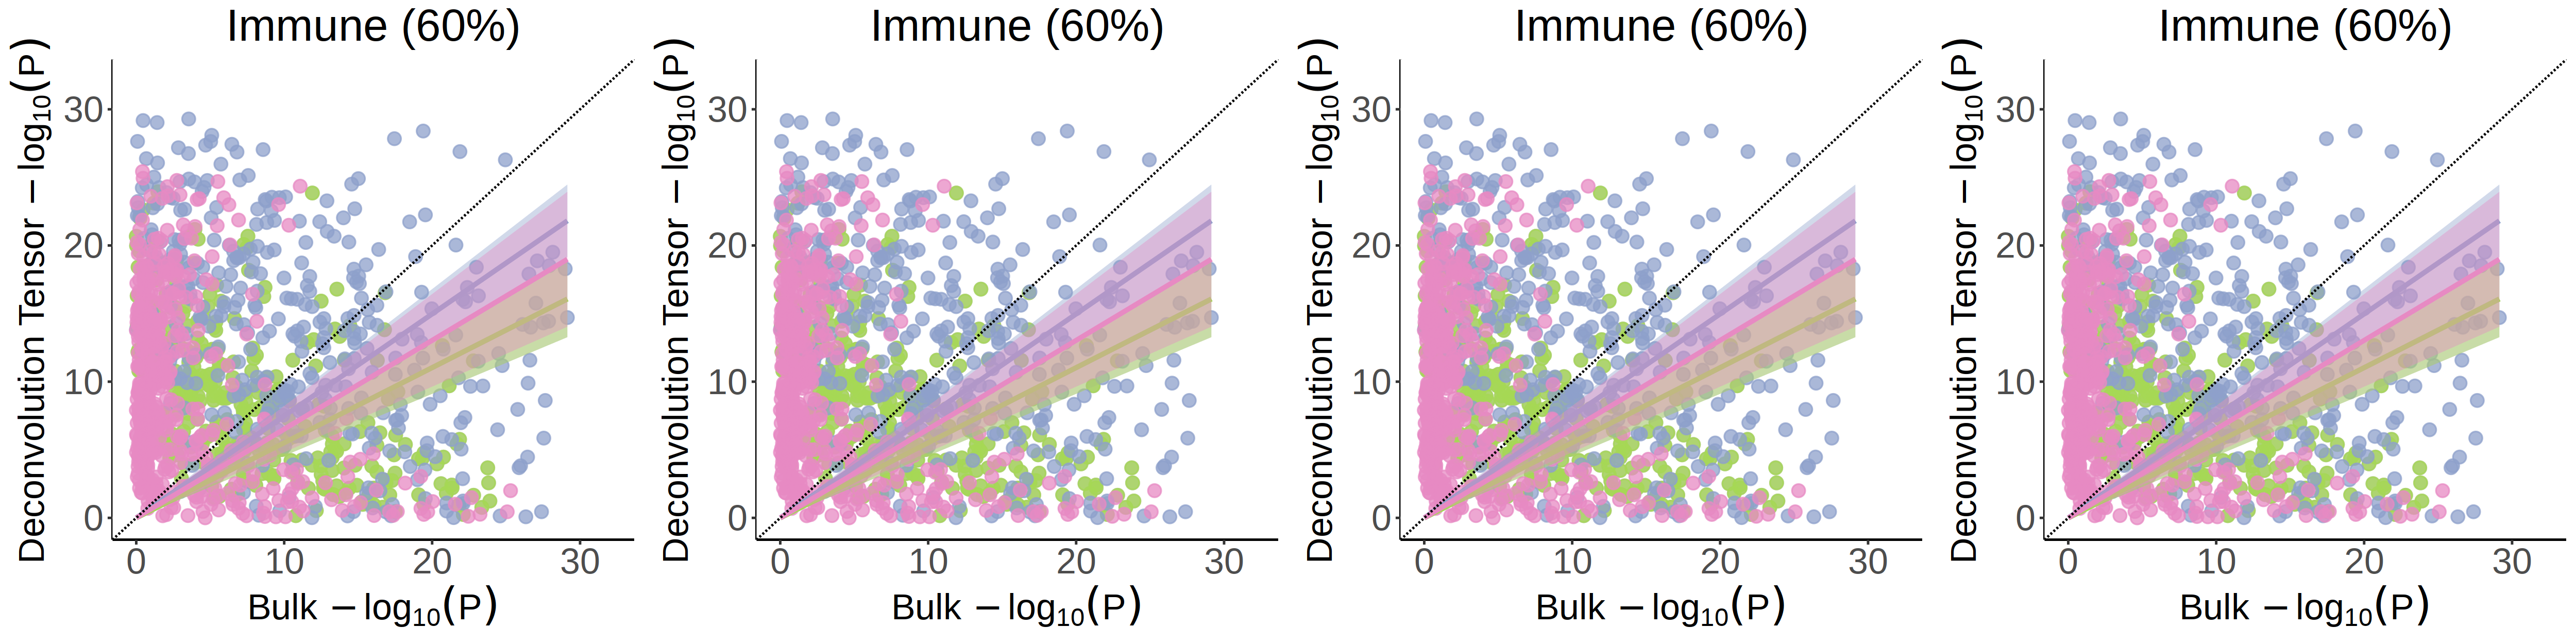

In [29]:
options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 250)
g = egg::ggarrange(plots = plts, align = "h", widths = rep(1, k)) 

In [30]:
plot.df.sub = plot.df [plot.df $method == "TCAx", ]

In [31]:
plot.df.sub

x            y          method
ENSG00000004059  10.214009513  1.1740340 TCAx  
ENSG00000008988  22.443605065  0.1153599 TCAx  
ENSG00000062582   9.028714100  4.5904773 TCAx  
ENSG00000071082   2.999623962  4.0636935 TCAx  
ENSG00000090581   1.313356319 13.4969202 TCAx  
ENSG00000100902  16.079377517  0.1723349 TCAx  
ENSG00000102119   1.145936457  7.9851246 TCAx  
ENSG000001023173  0.219476668  9.8769531 TCAx  
ENSG00000105193   0.813754746  9.6365518 TCAx  
ENSG00000106588  10.838723985  3.5506049 TCAx  
ENSG00000122026   4.846255508  3.8357616 TCAx  
ENSG00000124614  23.238471127  0.2652497 TCAx  
ENSG00000125691   1.497817881  7.6353898 TCAx  
ENSG00000129824   6.419617203  4.9394845 TCAx  
ENSG00000130255   2.354947763  8.6749608 TCAx  
ENSG00000131469   2.308401686  5.0101551 TCAx  
ENSG00000133983   4.344437137  5.9620713 TCAx  
ENSG00000136942   4.429232529  6.0628098 TCAx  
ENSG000001371542  0.852876191  5.2801896 TCAx  
ENSG00000140988   5.136189813  6.1130357 TCAx  
ENSG000001425342  0.003628662  7.9054834 TCAx  
ENSG00000142541  19.241301225  0.6907881 TCAx  
ENSG00000144426  19.702936139  0.4429872 TCAx  
ENSG00000147604   4.714481459  4.4516691 TCAx  
ENSG00000151366   7.233646442  5.5697784 TCAx  
ENSG00000153037   3.046910091  5.9970041 TCAx  
ENSG00000156411   5.776902227  3.4523438 TCAx  
ENSG00000161970   9.255248322  2.1550722 TCAx  
ENSG00000163463   5.376614234 12.0544728 TCAx  
ENSG00000163682  10.531141124  2.1231371 TCAx  
⋮                ⋮            ⋮          ⋮     
ENSG000001844323 0.20410523    9.6267982 TCAx  
ENSG000001636443 0.60482552    9.4742390 TCAx  
ENSG000001258103 1.47990875   13.6065094 TCAx  
ENSG000001981603 1.95794425   10.0232437 TCAx  
ENSG000001969613 0.04282580    6.0288875 TCAx  
ENSG000001143531 8.68561690    0.8273276 TCAx  
ENSG000001329633 1.09003227    2.7838894 TCAx  
ENSG000001109583 1.18538783   13.5163426 TCAx  
ENSG000001003533 2.49213470   16.4533470 TCAx  
ENSG000001790103 0.72699784    8.5913348 TCAx  
ENSG000000678293 1.55471183   19.3378499 TCAx  
ENSG000001975363 4.08179208    1.5133500 TCAx  
ENSG000002055443 2.03963973    8.7489124 TCAx  
ENSG000001020072 1.02735694    1.8376073 TCAx  
ENSG000001371333 1.44235842   17.1409558 TCAx  
ENSG000001177133 0.86411122    6.8591736 TCAx  
ENSG000001375003 1.22353624   10.4867136 TCAx  
ENSG000001721153 3.13492162   12.3030038 TCAx  
ENSG000001977473 0.47138047   14.5659822 TCAx  
ENSG000001118323 0.25385764    5.8687676 TCAx  
ENSG000001351853 2.04308543    0.2350768 TCAx  
ENSG000000897373 0.53997378    4.1602125 TCAx  
ENSG000001345313 1.80195143   10.5333770 TCAx  
ENSG000001864683 0.27433707    5.2883406 TCAx  
ENSG000001828993 0.01273866    4.8077372 TCAx  
ENSG000001155242 0.21960155    7.9588418 TCAx  
ENSG000001365222 0.44858821   15.8161346 TCAx  
ENSG000001168572 5.91331350   23.5065467 TCAx  
ENSG000001404553 6.90606220    0.7045856 TCAx  
ENSG000000338002 1.25965198    8.3740173 TCAx

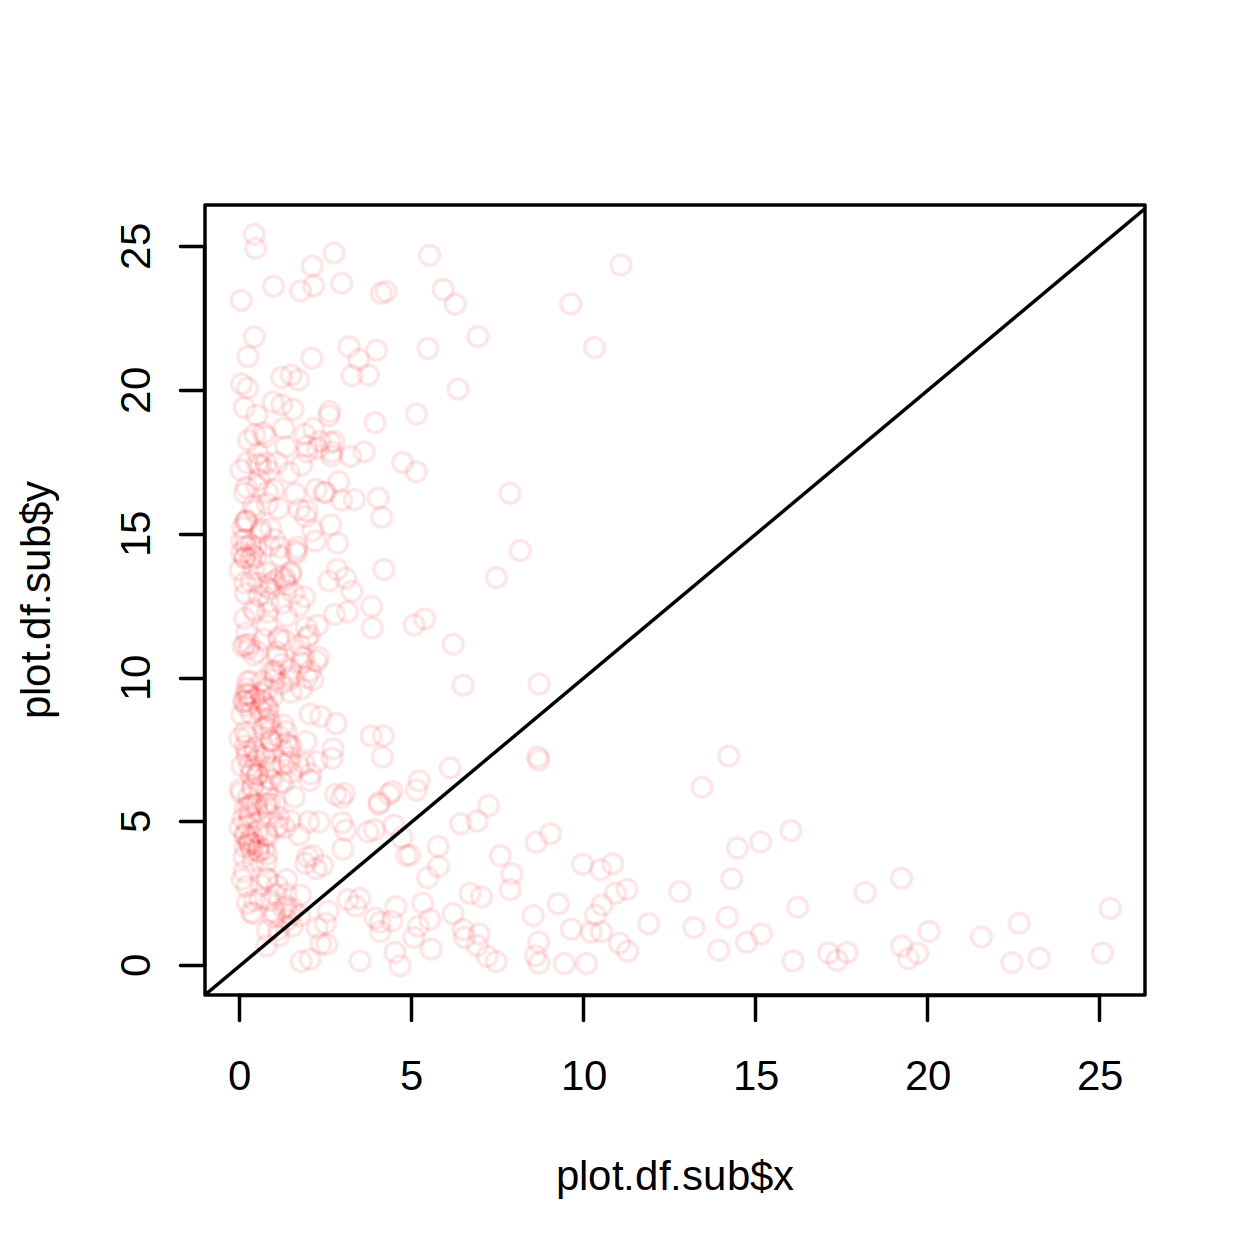

In [32]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 250)
plot(plot.df.sub$x, plot.df.sub$y,  col = alpha("red", 0.1))
abline(coef = c(0,1))

In [ ]:
[-log10(p.tensoer)] -[ -log10(p.bulk) ]

In [33]:
sum(plot.df.sub$y > plot.df.sub$x)/nrow(plot.df.sub)

[1] 0.7913223

In [34]:
lm(y~0 + x , data = plot.df.sub)


Call:
lm(formula = y ~ 0 + x, data = plot.df.sub)

Coefficients:
     x  
0.6517  


In [138]:
fit = lm(y~0 + x , data = plot.df.sub)

In [139]:
str(fit )

List of 12
 $ coefficients : Named num 0.872
  ..- attr(*, "names")= chr "x"
 $ residuals    : Named num [1:357] -5.2 -4.8 8.36 13.6 -9.88 ...
  ..- attr(*, "names")= chr [1:357] "ENSG00000004059" "ENSG00000062582" "ENSG00000071082" "ENSG00000090581" ...
 $ effects      : Named num [1:357] -66.75 -3.95 8.42 13.63 -9.18 ...
  ..- attr(*, "names")= chr [1:357] "x" "" "" "" ...
 $ rank         : int 1
 $ fitted.values: Named num [1:357] 7.574 12.108 0.823 0.548 9.959 ...
  ..- attr(*, "names")= chr [1:357] "ENSG00000004059" "ENSG00000062582" "ENSG00000071082" "ENSG00000090581" ...
 $ assign       : int 1
 $ qr           :List of 5
  ..$ qr   : num [1:357, 1] -76.5622 0.1814 0.0123 0.0082 0.1492 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:357] "ENSG00000004059" "ENSG00000062582" "ENSG00000071082" "ENSG00000090581" ...
  .. .. ..$ : chr "x"
  .. ..- attr(*, "assign")= int 1
  ..$ qraux: num 1.11
  ..$ pivot: int 1
  ..$ tol  : num 1e-07
  ..$ rank : int 1
  ..- attr(*, "

In [141]:
fit$ coefficients

x 
0.8717876

In [156]:
(1/t(as.matrix(plot.df.sub[,"y"])) %*% as.matrix(plot.df.sub[,"y"])) %*% t(as.matrix(plot.df.sub[,"y"])) %*% as.matrix(plot.df.sub[,"x"])

[,1]     
[1,] 0.1874933